In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

## Loading and Cleaning the Data

In [3]:
papers_ = spark.read.option("multiLine", True).option("mode", "PERMISSIVE").option("encoding", "ascii").json("../data/AL_papers.json")
papers = papers_.select(explode(col("hits.hits")).alias("paper"))

In [4]:
#papers.printSchema()

In [5]:
# short_papers = papers.select(
#     col("paper.created"),
#     element_at(col("paper.metadata.titles.title"),1).alias("title"),
#     element_at(col("paper.metadata.abstracts.value"),1).alias("abstract"),
#     col("paper.metadata.citation_count").alias("citation_count"),
#     col("paper.metadata.number_of_pages"),
#     col("paper.metadata.keywords"),
#     col("paper.metadata.authors.full_name").alias("authors"),
#     size(col("paper.metadata.references")).alias("num_refs")
# );
# short_papers.printSchema()

In [6]:
def ascii_ignore(x):
    return x.encode('ascii', 'ignore').decode('ascii')
ascii_udf = udf(ascii_ignore)


In [7]:
short_papers = papers.select(
    element_at(col("paper.metadata.titles.title"), 1).alias("title"),
    element_at(col("paper.metadata.abstracts.value"), 1).alias("abstract"),
    col("paper.created"), col("paper.metadata.number_of_pages"),
    col("paper.metadata.keywords"), size(
        col("paper.metadata.references")).alias("num_refs"),
    col("paper.metadata.authors.full_name").alias("authors")
).withColumn("title", ascii_udf("title"));
short_papers.printSchema()

root
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- created: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- schema: string (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- num_refs: integer (nullable = false)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Keywords Extraction

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

### Assigned

This is the list of assigned keywords from the whole dataset

In [9]:
kws  = short_papers.select(explode(col("keywords"))).select("col.value").withColumnRenamed("value", "K")
kws.show(5)

+--------------------+
|                   K|
+--------------------+
|            14.40.Pq|
|            12.39.St|
|            12.39.Jh|
|             3.38.Dg|
|Heavy quarkonia p...|
+--------------------+
only showing top 5 rows



Selecting 20 most used keywords

In [10]:
kws.groupby("K").count().sort(desc("count")).show(truncate=False)

+---------------------------------------+-----+
|K                                      |count|
+---------------------------------------+-----+
|numerical calculations                 |31   |
|CERN LHC Coll                          |21   |
|quantum chromodynamics: nonrelativistic|17   |
|LHC-B                                  |14   |
|14.40.Pq                               |13   |
|charmonium                             |12   |
|quarkonium: heavy                      |10   |
|electron positron: annihilation        |10   |
|13.66.Bc                               |10   |
|12.38.Bx                               |10   |
|13.25.Gv                               |10   |
|J/psi(3100): pair production           |8    |
|12.38.-t                               |7    |
|color: octet                           |7    |
|light cone                             |7    |
|color: singlet                         |7    |
|branching ratio                        |7    |
|quarkonium: pair production            

In [87]:
selected_keywords = kws.groupby("K").count().sort(desc("count")).limit(20).toPandas()["K"].tolist()
selected_keywords = [format_kwd(K) for K in selected_keywords + ["None"]
selected_keywords

['numerical calculations',
 'CERN LHC Coll',
 'quantum chromodynamics: nonrelativistic',
 'LHC-B',
 '14.40.Pq',
 'charmonium',
 'electron positron: annihilation',
 '12.38.Bx',
 'quarkonium: heavy',
 '13.25.Gv',
 '13.66.Bc',
 'J/psi(3100): pair production',
 'color: octet',
 '12.38.-t',
 'light cone',
 'color: singlet',
 'branching ratio',
 'p p: scattering',
 'channel cross section',
 'quarkonium: pair production',
 'None']

Extracting assigned keywords

In [14]:
# from https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [39]:
from pyspark.sql.functions import monotonically_increasing_id

In [115]:
import re

In [128]:
def format_kwd(kwd):
    return re.sub("[\.-/ :()]", "_", kwd)

In [129]:
# returns first keyword
@udf(returnType=ArrayType(StringType()))
def list_keywords(a):
    return [format_kwd(aa["value"]) for aa in a] if a else ["None"]

@udf(returnType=ArrayType(StringType()))
def filtered_list_keywords(a):
    kws_list = [aa["value"] for aa in a] if a else ["None"]
    kws_list = intersection(kws_list, selected_keywords)
    return kws_list if kws_list else ["None"]

withKeywords = short_papers.withColumn("keywords_", filtered_list_keywords(col("keywords"))).withColumn("id", monotonically_increasing_id())
withKeywords

title,abstract,created,number_of_pages,keywords,num_refs,authors,keywords_,id
Charmonia product...,"In this paper, pr...",2021-03-26T00:00:...,15,"[{PACS, null, 14....",35,"[Luchinsky, A.V.,...",[quantum chromody...,0
Exclusive decays ...,Exclusive decays ...,2020-07-09T00:00:...,10,"[{null, publisher...",42,"[Luchinsky, A.V.,...",[branching ratio],1
Doubly heavy bary...,The theoretical a...,2019-12-11T00:00:...,8,"[{INSPIRE, null, ...",40,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",2
Weak decays of do...,We consider exclu...,2019-05-29T00:00:...,10,"[{null, publisher...",21,"[Gerasimov, A.S.,...",[numerical calcul...,3
$B_c$ excitations...,Status of the Bc ...,2019-11-21T00:00:...,8,"[{INSPIRE, null, ...",49,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",4
Excited $\rho$ me...,"In this paper, ex...",2018-12-27T00:00:...,7,"[{null, publisher...",22,"[Luchinsky, A.V.]",[numerical calcul...,5
Doubly heavy bary...,The theoretical a...,2018-09-27T00:00:...,14,"[{null, publisher...",56,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",6
Charmonia Product...,In the presented ...,2018-01-30T00:00:...,9,"[{PACS, null, 14....",30,"[Luchinsky, A.V.]","[branching ratio,...",7
Lifetimes of Doub...,The inclusive dec...,2019-02-25T00:00:...,11,"[{INSPIRE, null, ...",49,"[Likhoded, A.K., ...",[None],8
Double Charmonia ...,This paper is dev...,2017-12-11T00:00:...,14,"[{PACS, null, 13....",36,"[Likhoded, A.K., ...","[14.40.Pq, quantu...",9


In [89]:
selected_keywords

['numerical calculations',
 'CERN LHC Coll',
 'quantum chromodynamics: nonrelativistic',
 'LHC-B',
 '14.40.Pq',
 'charmonium',
 'electron positron: annihilation',
 '12.38.Bx',
 'quarkonium: heavy',
 '13.25.Gv',
 '13.66.Bc',
 'J/psi(3100): pair production',
 'color: octet',
 '12.38.-t',
 'light cone',
 'color: singlet',
 'branching ratio',
 'p p: scattering',
 'channel cross section',
 'quarkonium: pair production',
 'None']

In [90]:
withKeywords.select(explode(col("keywords_"))).distinct().count()

21

In [91]:
from pyspark.sql.functions import array_contains
withKeywords.filter( array_contains(col("keywords_"), "charmonium"))

title,abstract,created,number_of_pages,keywords,num_refs,authors,keywords_,id
Production of hea...,Processes of sing...,2017-08-24T00:00:...,13,"[{INSPIRE, null, ...",57,"[Likhoded, A.K., ...","[CERN LHC Coll, q...",11
BC_NPI module for...,The module for th...,2011-04-05T00:00:...,15,"[{INSPIRE, null, ...",19,"[Berezhnoy, A.V.,...",[charmonium],38
Light hadron prod...,Decays of ground ...,2009-10-18T00:00:...,10,"[{PACS, null, 13....",26,"[Likhoded, A.K., ...",[numerical calcul...,46
Leading twist dis...,This paper is dev...,2008-10-20T00:00:...,8,"[{PACS, null, 13....",19,"[Braguta, V.V., L...","[12.38.Bx, 13.25....",50
Lepton pair produ...,Coherent producti...,2007-09-04T00:00:...,15,"[{PACS, null, 13....",10,"[Berezhnoy, A.V.,...",[numerical calcul...,54
Charmonium produc...,The production of...,2007-03-08T00:00:...,28,"[{INSPIRE, null, ...",30,"[Likhoded, A.K., ...",[numerical calcul...,55
Systematics of he...,"It is shown that,...",2007-06-15T00:00:...,10,"[{PACS, null, 14....",37,"[Gershtein, S.S.,...",[charmonium],56
The Processes e+ ...,In this paper we ...,2006-02-08T00:00:...,8,"[{PACS, null, 13....",13,"[Braguta, V.V., L...","[12.38.Bx, 13.25....",60
Systematics of he...,In this paper we ...,2006-02-08T00:00:...,9,"[{PACS, null, 14....",33,"[Gershtein, S.S.,...",[charmonium],62
Excited charmoniu...,In this paper the...,2005-07-25T00:00:...,7,"[{PACS, null, 13....",16,"[Braguta, V.V., L...","[12.38.Bx, 13.25....",64


Here are papers without any keywords

In [20]:
withKeywords.filter( array_contains(col("keywords_"), "charmonium")).count()

11

In [21]:
withKeywords.filter( array_contains(col("keywords_"), "numerical calculations")).count()

31

In [205]:
from pyspark.sql.functions import array_contains
withKeywords.filter( array_contains(col("keywords_"), "None"))

title,abstract,created,number_of_pages,keywords,num_refs,authors,keywords_
Lifetimes of Doub...,The inclusive dec...,2019-02-25T00:00:...,11,"[{INSPIRE, null, ...",49,"[Likhoded, A.K., ...",[None]
Exclusive process...,Results obtained ...,2012-04-17T00:00:...,12,"[{INSPIRE, null, ...",58,"[Braguta, V.V., L...",[None]
Scalar mesons in ...,The decay $\eta'\...,2009-02-19T00:00:...,6,"[{INSPIRE, null, ...",13,"[Donskov, S.V., L...",[None]
Scalar mesons sig...,The matrix elemen...,2010-02-04T00:00:...,6,"[{INSPIRE, null, ...",13,"[Donskov, S.V., L...",[None]
New Polarization ...,The new polarizat...,2007-12-17T00:00:...,8,null,6,"[Vasiliev, A.N., ...",[None]
Ortho-para conver...,The ortho-para co...,2002-04-24T00:00:...,7,"[{INSPIRE, null, ...",-1,"[Gershtein, S.S.,...",[None]
Experimental inve...,null,1999-04-08T00:00:...,20,null,27,"[Bystritsky, V.M....",[None]
Measuremen of the...,null,2015-09-11T00:00:...,4,null,-1,"[Bulgakov, T.L., ...",[None]


### Creating dummy variables

In [78]:
@udf(returnType=IntegerType())
def isin(kwds, kwd="aa"):
    if kwd in kwds:
        return 1
    return 0


In [83]:
from pyspark.sql.functions import lit

In [92]:
for k imselected_keywords[:2]

['numerical calculations', 'CERN LHC Coll']

In [103]:
["number_of_pages", "num_refs"]+selected_keywords

['number_of_pages',
 'num_refs',
 'numerical calculations',
 'CERN LHC Coll',
 'quantum chromodynamics: nonrelativistic',
 'LHC-B',
 '14.40.Pq',
 'charmonium',
 'electron positron: annihilation',
 '12.38.Bx',
 'quarkonium: heavy',
 '13.25.Gv',
 '13.66.Bc',
 'J/psi(3100): pair production',
 'color: octet',
 '12.38.-t',
 'light cone',
 'color: singlet',
 'branching ratio',
 'p p: scattering',
 'channel cross section',
 'quarkonium: pair production',
 'None']

In [107]:
selected_keywords

['numerical calculations',
 'CERN LHC Coll',
 'quantum chromodynamics: nonrelativistic',
 'LHC-B',
 '14.40.Pq',
 'charmonium',
 'electron positron: annihilation',
 '12.38.Bx',
 'quarkonium: heavy',
 '13.25.Gv',
 '13.66.Bc',
 'J/psi(3100): pair production',
 'color: octet',
 '12.38.-t',
 'light cone',
 'color: singlet',
 'branching ratio',
 'p p: scattering',
 'channel cross section',
 'quarkonium: pair production',
 'None']

In [113]:
dummy_df = withKeywords
for kw in selected_keywords:
    dummy_df = dummy_df.withColumn(kw.replace(".", "_"), isin(col("keywords_"), lit(kw)))

root
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- created: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- schema: string (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- num_refs: integer (nullable = false)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- keywords_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = false)
 |-- numerical calculations: integer (nullable = true)
 |-- CERN LHC Coll: integer (nullable = true)
 |-- quantum chromodynamics: nonrelativistic: integer (nullable = true)
 |-- LHC-B: integer (nullable = true)
 |-- 14_40_Pq: integer (nullable = true)
 |-- charmonium: integer (nullable = true)
 |-- electron positron: annihilation: integer (nullable = tr

In [110]:
selected_keywords[10].replace(".", "_")

'13_66_Bc'

In [101]:
dummy_df

title,abstract,created,number_of_pages,keywords,num_refs,authors,keywords_,id,numerical calculations,CERN LHC Coll,quantum chromodynamics: nonrelativistic,LHC-B,14.40.Pq,charmonium,electron positron: annihilation,12.38.Bx,quarkonium: heavy,13.25.Gv,13.66.Bc,J/psi(3100): pair production,color: octet,12.38.-t,light cone,color: singlet,branching ratio,p p: scattering,channel cross section,quarkonium: pair production,None
Charmonia product...,"In this paper, pr...",2021-03-26T00:00:...,15,"[{PACS, null, 14....",35,"[Luchinsky, A.V.,...",[quantum chromody...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Exclusive decays ...,Exclusive decays ...,2020-07-09T00:00:...,10,"[{null, publisher...",42,"[Luchinsky, A.V.,...",[branching ratio],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Doubly heavy bary...,The theoretical a...,2019-12-11T00:00:...,8,"[{INSPIRE, null, ...",40,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Weak decays of do...,We consider exclu...,2019-05-29T00:00:...,10,"[{null, publisher...",21,"[Gerasimov, A.S.,...",[numerical calcul...,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
$B_c$ excitations...,Status of the Bc ...,2019-11-21T00:00:...,8,"[{INSPIRE, null, ...",49,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Excited $\rho$ me...,"In this paper, ex...",2018-12-27T00:00:...,7,"[{null, publisher...",22,"[Luchinsky, A.V.]",[numerical calcul...,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Doubly heavy bary...,The theoretical a...,2018-09-27T00:00:...,14,"[{null, publisher...",56,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",6,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Charmonia Product...,In the presented ...,2018-01-30T00:00:...,9,"[{PACS, null, 14....",30,"[Luchinsky, A.V.]","[branching ratio,...",7,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Lifetimes of Doub...,The inclusive dec...,2019-02-25T00:00:...,11,"[{INSPIRE, null, ...",49,"[Likhoded, A.K., ...",[None],8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Double Charmonia ...,This paper is dev...,2017-12-11T00:00:...,14,"[{PACS, null, 13....",36,"[Likhoded, A.K., ...","[14.40.Pq, quantu...",9,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [84]:
withKeywords.withColumn("x", 
                        isin(col("keywords_"), lit("None"))
)

title,abstract,created,number_of_pages,keywords,num_refs,authors,keywords_,id,x
Charmonia product...,"In this paper, pr...",2021-03-26T00:00:...,15,"[{PACS, null, 14....",35,"[Luchinsky, A.V.,...",[quantum chromody...,0,0
Exclusive decays ...,Exclusive decays ...,2020-07-09T00:00:...,10,"[{null, publisher...",42,"[Luchinsky, A.V.,...",[branching ratio],1,0
Doubly heavy bary...,The theoretical a...,2019-12-11T00:00:...,8,"[{INSPIRE, null, ...",40,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",2,0
Weak decays of do...,We consider exclu...,2019-05-29T00:00:...,10,"[{null, publisher...",21,"[Gerasimov, A.S.,...",[numerical calcul...,3,0
$B_c$ excitations...,Status of the Bc ...,2019-11-21T00:00:...,8,"[{INSPIRE, null, ...",49,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",4,0
Excited $\rho$ me...,"In this paper, ex...",2018-12-27T00:00:...,7,"[{null, publisher...",22,"[Luchinsky, A.V.]",[numerical calcul...,5,0
Doubly heavy bary...,The theoretical a...,2018-09-27T00:00:...,14,"[{null, publisher...",56,"[Berezhnoy, A.V.,...","[CERN LHC Coll, L...",6,0
Charmonia Product...,In the presented ...,2018-01-30T00:00:...,9,"[{PACS, null, 14....",30,"[Luchinsky, A.V.]","[branching ratio,...",7,0
Lifetimes of Doub...,The inclusive dec...,2019-02-25T00:00:...,11,"[{INSPIRE, null, ...",49,"[Likhoded, A.K., ...",[None],8,1
Double Charmonia ...,This paper is dev...,2017-12-11T00:00:...,14,"[{PACS, null, 13....",36,"[Likhoded, A.K., ...","[14.40.Pq, quantu...",9,0


## Clustering

### Some example from https://runawayhorse001.github.io/LearningApacheSpark/clustering.html

https://stackoverflow.com/questions/44152337/hierarchical-agglomerative-clustering-in-spark

In [137]:
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

Reading and casting IRIS dataset

In [138]:
dataset = spark.read.option("header", True).csv("../data/iris.csv").\
    withColumnRenamed("sepal.length", "SL").\
    withColumnRenamed("sepal.width", "SW").\
    withColumnRenamed("petal.length", "PL").\
    withColumnRenamed("petal.width", "PW").\
    select( 
        col("SL").cast("float"),
        col("SW").cast("float"),
        col("PL").cast("float"),
        col("PW").cast("float"),
        col("variety")
    )
dataset.printSchema()

root
 |-- SL: float (nullable = true)
 |-- SW: float (nullable = true)
 |-- PL: float (nullable = true)
 |-- PW: float (nullable = true)
 |-- variety: string (nullable = true)



In [140]:
assembler = VectorAssembler().setInputCols(["SL", "SW", "PL", "PW"]).setOutputCol("features")
data_transformed = assembler.transform(dataset)
data_transformed

SL,SW,PL,PW,variety,features
5.1,3.5,1.4,0.2,Setosa,[5.09999990463256...
4.9,3.0,1.4,0.2,Setosa,[4.90000009536743...
4.7,3.2,1.3,0.2,Setosa,[4.69999980926513...
4.6,3.1,1.5,0.2,Setosa,[4.59999990463256...
5.0,3.6,1.4,0.2,Setosa,"[5.0,3.5999999046..."
5.4,3.9,1.7,0.4,Setosa,[5.40000009536743...
4.6,3.4,1.4,0.3,Setosa,[4.59999990463256...
5.0,3.4,1.5,0.2,Setosa,"[5.0,3.4000000953..."
4.4,2.9,1.4,0.2,Setosa,[4.40000009536743...
4.9,3.1,1.5,0.1,Setosa,[4.90000009536743...


In [101]:
data_transformed.select("variety").distinct()

variety
Virginica
Setosa
Versicolor


In [141]:
bkm = BisectingKMeans().setK(3).setSeed(1).setFeaturesCol("features")
kmean = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = kmean.fit(data_transformed)

In [98]:
model.clusterCenters()

[array([5.9016129 , 2.74838711, 4.39354837, 1.43387096]),
 array([5.006     , 3.42800001, 1.462     , 0.246     ]),
 array([6.84999998, 3.0736842 , 5.74210525, 2.07105261])]

In [109]:
preds = model.transform(data_transformed)

In [114]:
preds_ = preds.select("SL", "SW", "PL", "PW", "variety", "prediction").toPandas()

In [112]:
import matplotlib.pyplot as plt

In [117]:
import seaborn as sns

<AxesSubplot:xlabel='PL', ylabel='PW'>

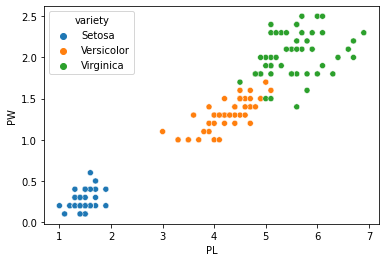

In [121]:
sns.scatterplot(data = preds_, x="PL", y="PW", hue="variety")

<AxesSubplot:xlabel='PL', ylabel='PW'>

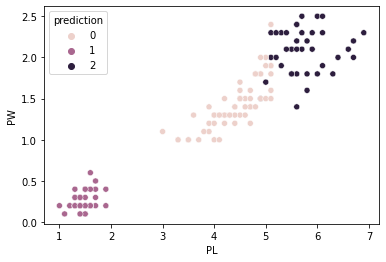

In [122]:
sns.scatterplot(data = preds_, x="PL", y="PW", hue="prediction")

In [128]:
preds_.columns

Index(['SL', 'SW', 'PL', 'PW', 'variety', 'prediction'], dtype='object')

In [142]:
preds.groupby("variety", "prediction").count().sort(desc("count"))

variety,prediction,count
Setosa,1,50
Versicolor,0,48
Virginica,2,36
Virginica,0,14
Versicolor,2,2


In [ ]:
from pyspark.ml.clustering import 